RNN 实现文本分类的步骤为以下几步:

1、**读取训练数据集(119979条随机排列数据)、测试数据集(39995条随机排列数据)**，样本的形式为-->(评论原文、标签(1,2,3)、预处理后的评论(空格分隔))。

2、根据预处理后的评论生成 **tokens 列表**，即 [['大片'，' 震撼']，['中国'， '加油']，[''，'']，，，] 这样的二维数组，列表每一个元素即一个评论分词列表。

3、**Word2Vec 词向量化**，将tokens投入Word2Vec模型，生成每一个词语对应的向量(一般100~300维)，并生成对应词典 id_token_voc，即['大片','震撼',,]等。

4、根据字典 id_token_voc 将评论 tokens 转化为其对应的索引下标 **tokens_index**，即[[0,545,264][1,4,854],,,]这样的二维数组，并**生成训练集与测试集列表**。

5、**构建 RNN 模型**，主要由 3 个部分构成，词嵌入矩阵Embedding、循环隐藏层RNN、全连接层Linear。

6、定义**梯度裁剪函数clip**，限制梯度的过度增长，防止梯度爆炸。

7、**初始化模型参数，选择损失函数、模型优化器、学习率、迭代次数等**。

8、定义模型训练函数与评估函数，**预测评估**。

具体的实现细节如下。

### Step1：读取数据集

读取训练集与测试集的数据，分别以3、2、1标签标识。

In [1]:
import csv

#传入训练集与测试集的文件名路径
def read_comments(train_file, test_file):
    train_array, test_array = [], []
    
    with open(train_file, 'r', encoding='UTF-8') as fp_train:
        reader_train = csv.reader(fp_train)
        train_array = [line for line in reader_train]                      #读取训练集所有数据
    
    with open(test_file, 'r', encoding='UTF-8') as fp_test:
        reader_test = csv.reader(fp_test)
        test_array = [line for line in reader_test]                        #读取测试集所有数据

    return train_array, test_array

In [2]:
train_array, test_array = read_comments('./alldata/train-all.csv', './alldata/test-all.csv')

查看读取到的信息，训练集测试集长度，训练集与测试集的前3个数据。

In [3]:
len(train_array), len(test_array), train_array[1:4], test_array[1:4]

(119979,
 39995,
 [['很震撼！全程无尿点，就是男主演技有点生硬，有待提高。', '3', '  震撼 全程无 尿点 主演 生硬 有待 提高'],
  ['一直习惯好评', '3', '  习惯 好评'],
  ['大片 太震撼 涉及人性 感情 触动内心 支持吴京 支持中国', '3', '  大片 震撼 涉及 人性 感情 触动 内心 支持 吴京 中国']],
 [['吹爆这部电影，二刷了。第一次3d，这次imax。果然还是imax效果好，能看imax就别看3d了。特效真的很好，虽然台词有些欠缺，但还是很推荐！',
   '3',
   '  这部 电影 二刷 第一次 3d imax 效果 就别 特效 真的 台词 欠缺 推荐'],
  ['还可以吧??', '2', ' '],
  ['?中国电影加油！期待超越！', '3', '  中国 电影 加油 期待 超越']])

可以看到，每条样本的形状均是-->(评论原文、标签(1,2,3)、预处理后的评论(空格分隔))。

### Step2：生成 tokens 数组

生成 tokens 数组要将训练集与测试集的所有评论信息进行**汇总生成**，否则 tokens 数据不健壮，预测时发生异常。

In [4]:
def create_tokens(train_array, test_array):
    
    tokens = []
    
    #追加训练集的tokens
    for comment_data in train_array:
        tokens.append(comment_data[2].split(' '))
        
    #追加测试集的tokens
    for comment_data in test_array:
        tokens.append(comment_data[2].split(' '))
    
    return tokens                      #返回数据集的所有tokens

获取数据集的所有tokens

In [5]:
tokens = create_tokens(train_array, test_array)

打印前 3 条评论的 tokens

In [6]:
tokens[1:4]

[['', '', '震撼', '全程无', '尿点', '主演', '生硬', '有待', '提高'],
 ['', '', '习惯', '好评'],
 ['', '', '大片', '震撼', '涉及', '人性', '感情', '触动', '内心', '支持', '吴京', '中国']]

### Step3：使用Word2Vec生成词向量

我们知道，在神经网络中，网络的输入和输出一般均为数值型数据，且多数为**向量矩阵操作**，所以我们使用 Word2Vec 对评论中的每个词语进行编码。

In [7]:
from gensim.models import Word2Vec

def word_vec(tokens):
    
    #调用Word2Vec模型，将所有词语信息转化为向量
    model = Word2Vec(tokens, sg=0, vector_size=300, window=5, min_count=1, epochs=7, negative=10)
    model.save('word2vec_model')
    
    return model

进行单词的编码操作。

In [8]:
word_vecs = word_vec(tokens=tokens)

输出词向量后的信息。

In [9]:
print(word_vecs.wv.vectors.shape)                                    #输出所有向量总的形状
print(word_vecs.wv.index_to_key[:5])                                 #所有的词表信息['word1', 'word2', ,,,]，输出前5个
print(word_vecs.wv.vectors[:5])                                      #输出前5个词对应的向量信息，并输出总的形状

(45208, 300)
['', '好看', '中国', '电影', '不错']
[[ 0.15714452  0.10297985 -0.3767757  ...  0.00725677 -0.06473741
  -0.480472  ]
 [-0.20987633  0.06765148  0.05508094 ... -0.5220865   0.8101194
  -0.8843229 ]
 [ 1.0823553  -0.48328546  0.53041005 ...  1.2825646   0.85334855
  -0.40326372]
 [-0.82389003 -0.4161417  -0.3203291  ... -0.8774252  -0.5733916
  -0.15823705]
 [-0.78325015 -0.00408868  0.68230563 ...  0.22523704  0.2063678
   0.1848022 ]]


可见，存在12290个词语，每个词语均使用300维(长度)的向量来表示。

此时，也应生成该向量矩阵对应的词典，用于将所有评论句子内的**词语信息**转化为**向量索引**。

In [10]:
id_token_voc = word_vecs.wv.index_to_key

输出字典内的前 10 个词语：

In [11]:
id_token_voc[:10]

['', '好看', '中国', '电影', '不错', '特效', '科幻片', '科幻', '国产', '剧情']

### Step4：将 tokens 内的词语转化为向量索引

In [12]:
def word_to_idx(tokens, id_token_voc):
    tokens_index = []
    
    for sentence in tokens:                                #遍历所有评论
        index = []
        for word in sentence:
            index.append(id_token_voc.index(word))         #将每个单词转化为字典对应的索引
        tokens_index.append(index)
    
    return tokens_index                                   #返回所有评论的索引列表

将所有评论词语转化为向量索引:

In [13]:
tokens_index = word_to_idx(tokens, id_token_voc)

输出前两个评论的 tokens 索引列表:

In [14]:
tokens_index[:2]

[[19547], [0, 0, 10, 152, 137, 256, 291, 409, 372]]

并输出这两条评论对应的文本信息:

In [15]:
[id_token_voc[id] for id in tokens_index[0]], [id_token_voc[id] for id in tokens_index[1]]

(['comment_cut'], ['', '', '震撼', '全程无', '尿点', '主演', '生硬', '有待', '提高'])

可见，句子是正确有逻辑的，所以 tokens_index 评论词语索引列表生成正确。

### Step5：生成训练集与测试集

同样地，我们将生成训练集和测试集的数据迭代器，每一个样本均包含对应的评论索引列表和其对应的标签。如下

In [16]:
import torch
torch.FloatTensor([5,3,5])

tensor([5., 3., 5.])

In [17]:
#生成训练集与测试集的数据迭代器
def get_iter(train_array, test_array, tokens_index):
    train_iter = [[torch.tensor(tokens_index[i]), torch.tensor(int(train_array[i][1]))] for i in range(len(train_array))]
    test_iter = [[torch.tensor(tokens_index[i+len(train_array)]), torch.tensor(int(test_array[i][1]))] for i in range(len(test_array))]
    return train_iter, test_iter


train_iter, test_iter = get_iter(train_array, test_array, tokens_index)

测试一下训练集与测试集的长度，以及训练集的前5个样本:

In [18]:
len(train_iter), len(test_iter), train_iter[:5]

(119979,
 39995,
 [[tensor([19547]), tensor(1)],
  [tensor([  0,   0,  10, 152, 137, 256, 291, 409, 372]), tensor(3)],
  [tensor([   0,    0, 1245,  105]), tensor(3)],
  [tensor([   0,    0,   14,   10, 1716,  177,   87,  561,  524,   26,   18,    2]),
   tensor(3)],
  [tensor([  0,   0,   2,  57, 713,  24,   7,  14]), tensor(3)]])

符合预期，创建成功。

### Step6：构建RNN循环神经模型

要想更加本质的理解这一部分的内容，我想还是应该把 RNN 的图示和计算公式贴在这里，更能方便大家理解。

RNN的**核心公式**如下。

隐状态 $H$:

$$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}  + \mathbf{b}_h).$$

输出结果 $O$:

$$O_{t} = H_{t}W_{hq} + b_q$$

其中，添加了 ${H}_{t-1}$ 代表上个时序**隐状态**，${W}_{hh}$ 代表了其对应的**权重矩阵**, $O_{t}$代表**时间段t的输出**。

图示如下:

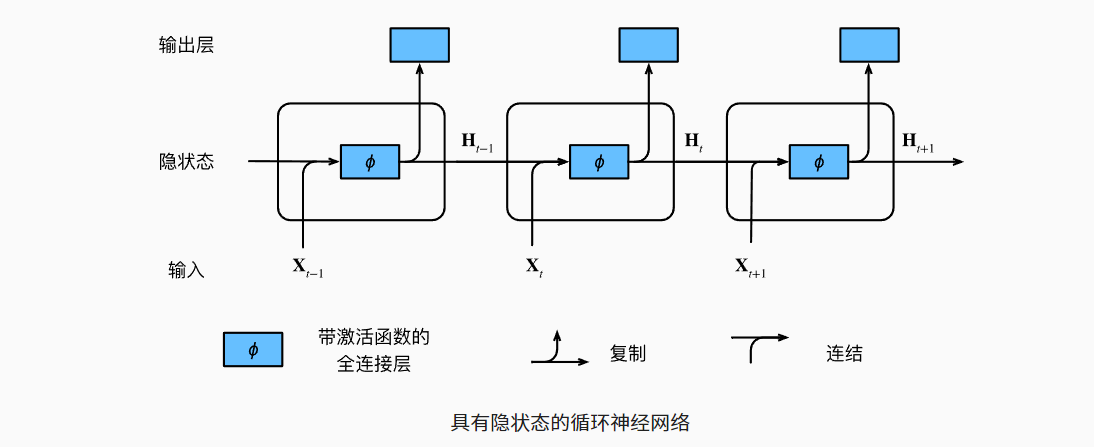

由此可见，要想使用 RNN 网络预测得到结果，我们大体上需要两个部分组成：**RNN层(生成最终隐状态 $H$ )、Linear全连接层(生成结果 $O$)**。

但是我们又需要将所有评论语句变为向量投入到网络中，所以还需要一部分**Embedding词嵌入**模型，用于将所有的评论信息转化为矩阵信息，所以共需要三部分构成。下面来定义RNN模型：

In [19]:
import torch
from torch import nn
import torch.nn.functional as F

class RNNModel(nn.Module):
    
    #初始化模型
    def __init__(self, id_token_voc, embedding_dim, hidden_dim, output_dim, vectors):
        super(RNNModel, self).__init__()
        
        #生成词嵌入的矩阵
        self.embedding = nn.Embedding(len(id_token_voc), embedding_dim)
        self.embedding = self.embedding.from_pretrained(torch.tensor(vectors))
        
        #RNN循环隐藏层，计算出最后的H隐状态
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        #Linear全连接层，用于输出最后的分类结果概率
        self.linear = nn.Linear(hidden_dim, output_dim)

    #前向传播函数，计算分类结果
    def forward(self, X):
        
        #将X评论语句的词语索引均转化为对应的向量
        #此时的embedded的形状为 (评论长度(词语个数)、批量数目、词向量维度)
        #因为我们之前并未统一评论的长度，不能够批量训练样本数据、所以此次训练批量数目均为1
        embedded = self.embedding(X.long().T)
        
        #RNN层计算出隐状态列表(h_1, h_2, ,,, h_n)
        #其中 out 代表所有时间步 t_i 的隐状态(h_1, h_2, ,,, h_n)
        #其中 h 代表最后一个时间步的隐状态 h_n
        #out.shape(评论长度(词语个数)、批量数目、隐单元维度)、h.shape(1, 批量数目，隐单元维度)，注意本文章的批量数目均为1
        out, h = self.rnn(embedded)
        
        #断言最后一个隐状态h_n是否等于h_n
        #h.squeeze()方法为压缩维度，将第0个维度取出，即h.squeeze(0).shpae = (批量数目1，隐单元维度)
        assert torch.equal(out[-1, :, ], h.squeeze(0))

        #最后通过全连接层计算结果Out，并以softmax()回归规范数据
        return F.softmax(self.linear(h.squeeze()),dim=0)

### Step7：定义梯度裁剪方法

梯度裁剪，顾名思义，就是对梯度进行限制，防止出现**梯度爆炸**的情况，以免影响模型训练。

具体的裁剪方法如下公式所示:

$$g \leftarrow min(1, \frac{\theta}{||g||})g$$

其中， $||g||$代表**梯度的二范数**, $\theta$ 代表**设定范围**。

In [20]:
def grad_clipping(net, theta):  # @save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params

    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))      #计算梯度的二范数
    
    if norm > theta:                                                      #如果梯度的二范数大于设定值时，进行梯度裁剪操作
        for param in params:
            param.grad[:] *= theta / norm

### Step8：初始化模型参数、损失函数、优化算法

现在，我们来实例化RNN模型，并初始化模型参数。

In [21]:

from d2l import torch as d2l

#初始化模型参数函数，均为正态分布
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.RNN:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

#实例化模型并初始化模型参数，并尝试使用gpu进行训练
net = RNNModel(id_token_voc=id_token_voc, embedding_dim=300, hidden_dim=256, output_dim=3, vectors=word_vecs.wv.vectors)
net.apply(init_weights)

#device = d2l.try_gpu()

net = net.to(d2l.try_gpu())
#net = net.to(torch.device('cpu'))

#设置词嵌入矩阵不计入梯度的计算
net.embedding.weight.requires_grad = False

#定义交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

#定义梯度下降方法优化器
updater = torch.optim.SGD(net.parameters(), 0.0001)

C:\Users\sxs\Desktop\新建文件夹partdata\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\sxs\Desktop\新建文件夹partdata\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Step9：定义训练模型函数，训练模型

现在，我们需要定义训练函数，从而对模型进行训练。

首先定义一个评估函数，每次迭代一次后均要评测模型对训练集与测试集的精确度。

In [22]:
def evaluate_net(net, train_iter, test_iter, device):
    
    correct_train = 0
    correct_test = 0
    error_train = 0
    error_test = 0
    
    #统计训练集的预测正确与预测错误的数目
    for X, y in train_iter:
        
        X = X.unsqueeze(0)
        
        X = X.to(device)
        y = y.to(device)
        
        y_hat = net(X)
        
        if y_hat.argmax().item() + 1 == y.item():
            correct_train += 1
        else:
            error_train += 1
    
    #统计测试集的预测正确与预测错误的数目
    for X, y in test_iter:
        
        X = X.unsqueeze(0)
        
        X = X.to(device)
        y = y.to(device)
        
        y_hat = net(X)
        
        if y_hat.argmax().item() + 1 == y.item():
            correct_test += 1
        else:
            error_test += 1
    
    #返回模型在训练集与测试集上的准确度
    return correct_train/len(train_iter), correct_test/len(test_iter)
    

现在来定义训练函数。

In [23]:
def train(net, train_iter, test_iter, loss, updater, num_epochs, device):
    print('----------开始训练----------')
    
    import time
    
    for i in range(num_epochs):        #共迭代num_epochs次
        
        num = 0
        loss_sum = 0     
        
        for X, y in train_iter:
            
            X = X.unsqueeze(0)         #增加一个维度，表示批量大小为1， 此时X的形状为(1, 词语个数(序列索引))
            
            X = X.to(device)
            y = y.to(device)
            
            y_hat = net(X)            #通过RNN循环神经网络预测y_hat, 会返回(1, 3)的概率列表，表示三个类别的概率分布
            
            updater.zero_grad()       #清空梯度
            
            #之所以(y-1).long() 是因为y代表的是标签123，并不是概率列表下标012，所以要 (y-1)将标签换做成下标计算损失
            l = loss(y_hat, (y-1).long())
            
            l.backward()             #后向传播计算梯度，更新模型参数
            updater.step()
            
            grad_clipping(net, 1)    #进行梯度裁剪
            
            num += 1                 #训练样本个数累加
            loss_sum += l            #训练损失累加
        
        
        train_acc, test_acc = evaluate_net(net, train_iter, test_iter, device)
        
        #输出迭代次数、损失、训练集准确度、测试集准确度
        stamptime = time.strftime("%H:%M:%S", time.localtime())
        #print('-epochs:', (i+1),  '\t-loss:', loss_sum/num, '\t-train-acc:', train_acc, '\t-test-acc:', test_acc)
        print('-epochs:', (i+1),  '\t-loss:', loss_sum/num, '\t-train-acc:', train_acc, '\t-test-acc:', test_acc, '---',stamptime)
                
    
    #保存模型参数，方便下次使用时直接进行加载
    torch.save(net.state_dict(), 'RNN.parameters')        

### Step10：训练和评估模型

In [24]:

train(net, train_iter, test_iter, loss, updater, 50, d2l.try_gpu())
#train(net, train_iter, test_iter, loss, updater, 50, torch.device('cpu'))

----------开始训练----------
-epochs: 1 	-loss: tensor(0.6509, device='cuda:0', grad_fn=<DivBackward0>) 	-train-acc: 0.906300269213779 	-test-acc: 0.9024878109763721 --- 16:11:11
-epochs: 2 	-loss: tensor(0.6455, device='cuda:0', grad_fn=<DivBackward0>) 	-train-acc: 0.906300269213779 	-test-acc: 0.9024878109763721 --- 16:15:07


KeyboardInterrupt: 

由下图的运行结果可见，随着损失的不断减少，训练集与预测集的准确准确度也在不断提高。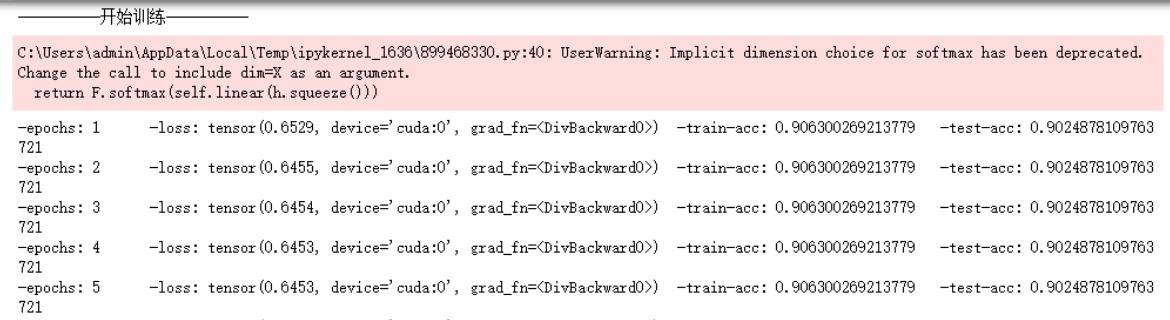

### 情感预测分类

In [25]:
#加载已经保存的模型参数
net.load_state_dict(torch.load('./RNN.parameters'))
device = d2l.try_gpu()

for X, y in test_iter[:20]:            #对测试集的前20个样本进行测试


    X = X.to(device)
    y = y.to(device)

    #输出样本的评论语句信息
    print(' '.join([id_token_voc[i] for i in X]))

    X = X.unsqueeze(0)
    y_hat = net(X)

    print('-预测类别:', y_hat.argmax().item() + 1 ,'\t-实际类别:', y.item(), end='\t')

    if y_hat.argmax().item() + 1 == y.item():
        print('\t-预测正确\n')

    else:
        print('\t-预测错误\n')

comment_cut
-预测类别: 3 	-实际类别: 1		-预测错误

  这部 电影 二刷 第一次 3d imax 效果 就别 特效 真的 台词 欠缺 推荐
-预测类别: 3 	-实际类别: 3		-预测正确



部分运行结果如下图:

In [26]:
from sklearn.metrics import classification_report
import torch
import d2l  # 确保d2l库已导入（原代码中使用了d2l.try_gpu()）

# 加载模型
net.load_state_dict(torch.load('./RNN.parameters'))
# device = d2l.try_gpu()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# 收集标签
y_true = []
y_pred = []
for X, y in test_iter:
    X = X.unsqueeze(0).to(device)
    y_true.append(y.item())  # 真实标签（1,2,3）
    with torch.no_grad():
        y_hat = net(X)
        pred = y_hat.argmax().item() + 1  # 预测标签（1,2,3）
        y_pred.append(pred)

# 生成分类报告
target_names = ['差评', '中评', '好评']  # 对应标签1,2,3
print(classification_report(y_true, y_pred, target_names=target_names))
#print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          差评       0.00      0.00      0.00      2271
          中评       0.00      0.00      0.00      1629
          好评       0.90      1.00      0.95     36095

    accuracy                           0.90     39995
   macro avg       0.30      0.33      0.32     39995
weighted avg       0.81      0.90      0.86     39995



C:\Users\sxs\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\sxs\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\sxs\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape